In [42]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
import pickle
sys.path.append("../")
from models import PracticalBNCNN, NormedBNCNN, DalesBNCNN, DalesSSCNN, SSCNN, BNCNN, PracticalBNCNN, DalesHybrid, DalesSkipBNCNN, SkipBNBNCNN
#import metrics
import matplotlib.pyplot as plt
from utils.deepretina_loader import loadexpt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import scipy.cluster as cluster
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    rp.step_response(bn_cnn)
    rp.osr(bn_cnn)
    rp.reversing_grating(bn_cnn)
    rp.contrast_adaptation(bn_cnn, .35, .05)
    rp.motion_anticipation(bn_cnn)
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stim, stim_type):
    if stim_type == 'boxes':
        return 2*stim - 1
    elif stim_type == 'flashes':
        stim = stim.reshape(stim.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stim, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    elif stim_type == 'lines':
        stim_averaged = np.apply_along_axis(lambda m: np.convolve(m, 0.5*np.ones((2,)), mode='same'), 
                                            axis=1, arr=stim)
        stim = stim_averaged[:,::2]
        # now stack stimulus to convert 1d to 2d spatial stimulus
        return stim.reshape(-1,1,stim.shape[-1]).repeat(stim.shape[-1], axis=1)
    else:
        print("Invalid stim type")
        assert False
    
def index_of(arg, arr):
    for i in range(len(arr)):
        if arg == arr[i]:
            return i
    return -1

In [2]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [26]:
cells = [0,1,2,3,4]
dataset = '15-10-07'
norm_stats = [51.49175, 53.62663279042969]
test_data = loadexpt(dataset,cells,'naturalscene','test',40,0, norm_stats=norm_stats)
test_y = torch.FloatTensor(test_data.y)
test_x = torch.FloatTensor(test_data.X)
test_x.requires_grad=True

In [8]:
grand_folder = "dalesBNnobias"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [9]:
model_folders = sorted(model_folders)
print("\n".join(model_folders))

dalesBNnobias/dalesBNnobias_0_lr0.01_l10.0001_l20.01
dalesBNnobias/dalesBNnobias_10_lr0.0001_l11e-06_l20.01
dalesBNnobias/dalesBNnobias_11_lr0.0001_l11e-06_l20.005
dalesBNnobias/dalesBNnobias_12_lr1e-05_l10.0001_l20.01
dalesBNnobias/dalesBNnobias_13_lr1e-05_l10.0001_l20.005
dalesBNnobias/dalesBNnobias_14_lr1e-05_l11e-06_l20.01
dalesBNnobias/dalesBNnobias_15_lr1e-05_l11e-06_l20.005
dalesBNnobias/dalesBNnobias_1_lr0.01_l10.0001_l20.005
dalesBNnobias/dalesBNnobias_2_lr0.01_l11e-06_l20.01
dalesBNnobias/dalesBNnobias_3_lr0.01_l11e-06_l20.005
dalesBNnobias/dalesBNnobias_4_lr0.001_l10.0001_l20.01
dalesBNnobias/dalesBNnobias_5_lr0.001_l10.0001_l20.005
dalesBNnobias/dalesBNnobias_6_lr0.001_l11e-06_l20.01
dalesBNnobias/dalesBNnobias_7_lr0.001_l11e-06_l20.005
dalesBNnobias/dalesBNnobias_8_lr0.0001_l10.0001_l20.01
dalesBNnobias/dalesBNnobias_9_lr0.0001_l10.0001_l20.005


In [13]:
folder = model_folders[11]
for i in range(250):
    file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
    try:
        with open(file, "rb") as fd:
            temp = torch.load(fd)
        losses.append(temp['loss'])
        val_losses.append(temp['val_loss'])
        val_accs.append(temp['val_acc'])
    except:
        break
bn_cnn = temp['model']
bn_cnn = bn_cnn.to(DEVICE)
bn_cnn.eval()

DalesBNCNN(
  (sequential): Sequential(
    (0): AbsConv2d(
      (conv): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1), bias=False)
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05)
    (4): ReLU()
    (5): Reshape()
    (6): DaleActivations(n_chan=8, neg_p=0.5, n_neg_chan=4)
    (7): AbsConv2d(
      (conv): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1), bias=False)
    )
    (8): Flatten()
    (9): BatchNorm1d(5408, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (10): GaussianNoise(std=0.05)
    (11): ReLU()
    (12): Reshape()
    (13): DaleActivations(n_chan=8, neg_p=0.5, n_neg_chan=4)
    (14): Flatten()
    (15): AbsLinear(
      (linear): Linear(in_features=5408, out_features=5, bias=False)
    )
    (16): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): Softplus(beta=1, threshold=20)
  )
)

In [28]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 7198.32 mb


## Find instantaneous receptive field

In [19]:
for p in bn_cnn.parameters():
    try:
        p.requires_grad = False
    except:
        pass

In [23]:
loss_fxn = torch.nn.PoissonNLLLoss()

In [27]:
batch_size = 500
for i in range(0,test_x.shape[0], batch_size):
    batch_x = test_x[i:i+batch_size].to(DEVICE)
    batch_y = test_y[i:i+batch_size].to(DEVICE)
    preds = bn_cnn(batch_x)
    loss = loss_fxn(preds, batch_y)
    loss.backward()

In [37]:
grad = test_x.grad.data

In [40]:
grad = grad.view(grad.shape[0], -1).detach().numpy()

In [44]:
whitened = cluster.vq.whiten(grad)
clust,distort = cluster.vq.kmeans(whitened, 8)

In [48]:
clust = clust.reshape((-1, 40, 50, 50))

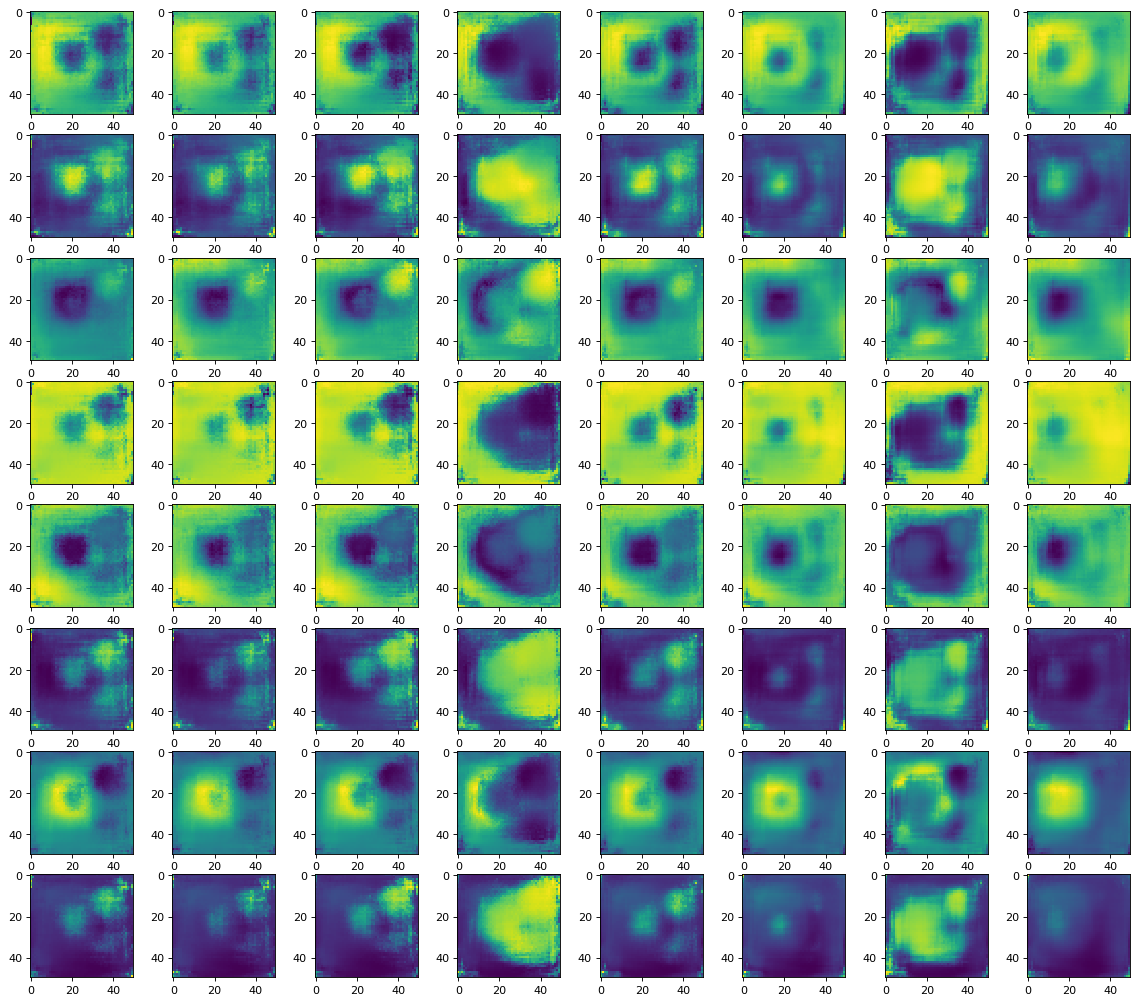

In [53]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,1 + i*8+j)
        plt.imshow(clust[i,j*5,:,:])
plt.show()

## Look at model performances

Using layers: sequential.2 and sequential.8
Folder: test/bncnn_0_lr0.005_l10.001_l20.05
Final Loss: -1.6604126444589318
Final Val: -2.6593296825885773
Final Val Acc: 0.26807584166526793

Final Test Acc: 0.659284415538977


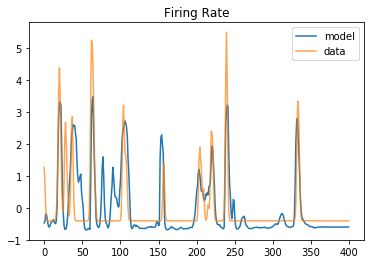

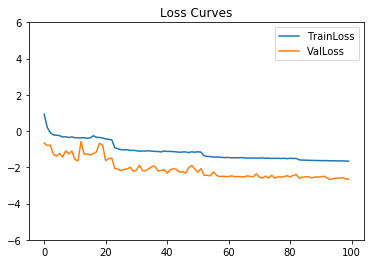

100%|██████████| 10/10 [00:00<00:00, 57.89it/s]
51it [00:00, 198.73it/s]


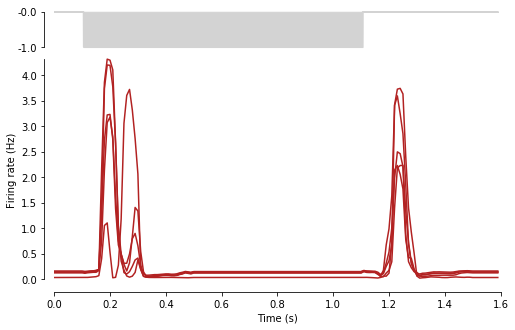

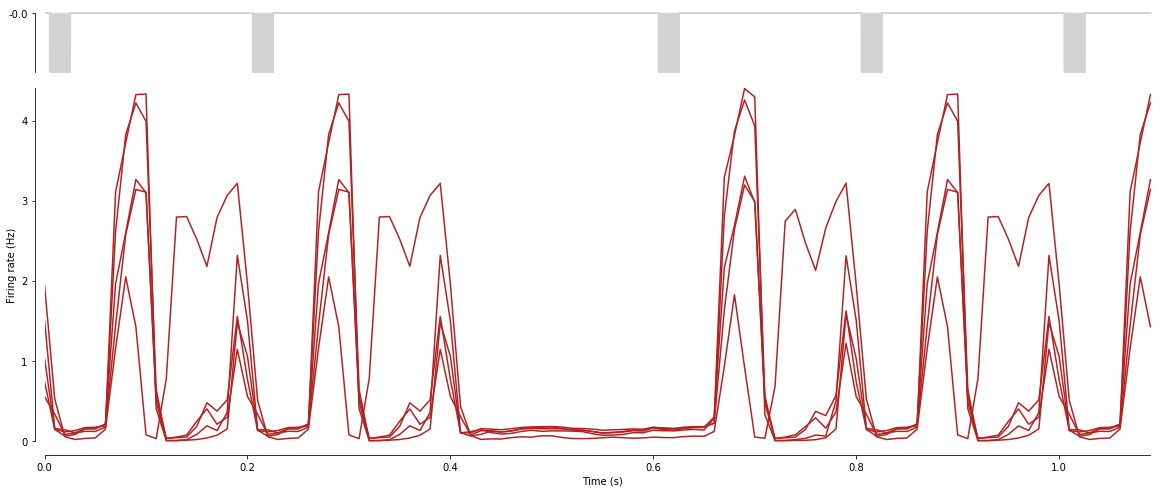

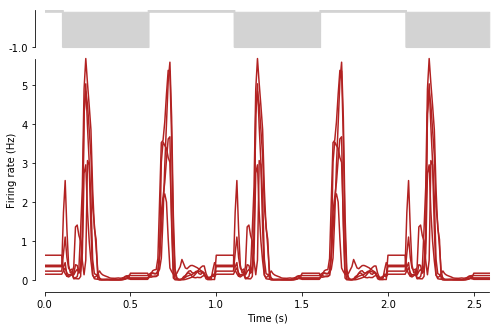

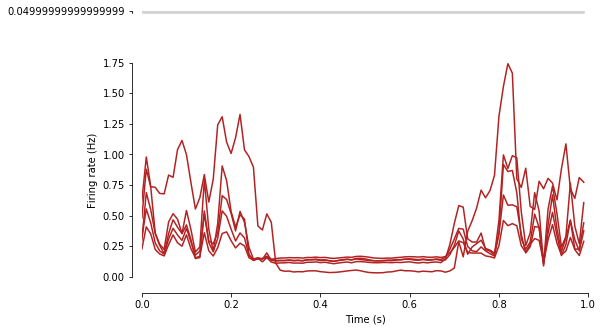

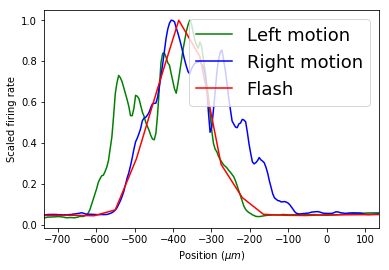

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:28<00:00, 24.82s/it]


Mean intracellular: 0.379514576252839
Std intracellular: 0.0878468992143236
Min intracellular: 0.09517904833334229
Max intracellular: 0.552467292308735
Layer sequential.2 correlation map


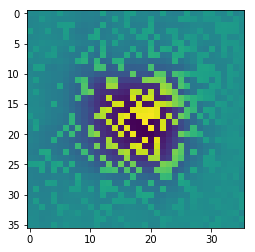

bipolar


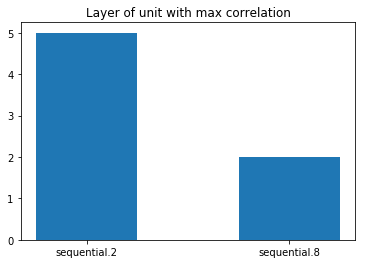

amacrine


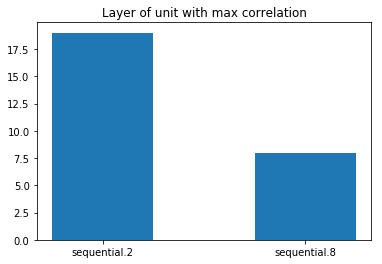

horizontal


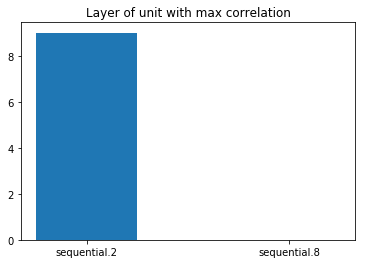

Receptive field of boxes model cell in Layer 0


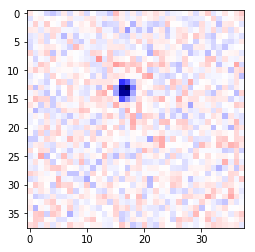

Receptive field of boxes model cell in Layer 1


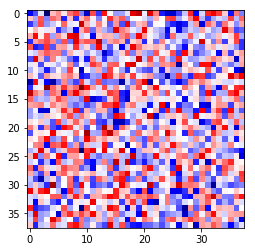

Memory Used: 8162.87 memory
Completed in 177.36032962799072 seconds





Best by validation loss: test/bncnn_0_lr0.005_l10.001_l20.05
Best by training loss: test/bncnn_0_lr0.005_l10.001_l20.05
Best by val accuracy: test/bncnn_0_lr0.005_l10.001_l20.05
Best by test accuracy: test/bncnn_0_lr0.005_l10.001_l20.05
Best by intracellular correlation: test/bncnn_0_lr0.005_l10.001_l20.05


In [11]:
n_epochs = 250
best_folder_by_loss = ""
best_loss = 100
best_folder_by_val_loss = ""
best_val_loss = 100
best_folder_by_val_acc = ""
best_val_acc = -100
best_folder_by_test_acc = ""
best_test_acc = -100
best_folder_by_intr_cor = ""
best_intr_cor = -1

results_file_name = grand_folder + "_analysis_results.txt"
results_file = open(results_file_name, 'a')
batch_compute_size = 3000

# load the losses
print("Using layers:", " and ".join(conv_layers))
for folder in model_folders:
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                temp = torch.load(fd)
            losses.append(temp['loss'])
            val_losses.append(temp['val_loss'])
            val_accs.append(temp['val_acc'])
        except:
            break
    bn_cnn = temp['model']
    bn_cnn = bn_cnn.to(DEVICE)
    bn_cnn.eval()
    print("Folder:", folder)
    results_file.write(folder + "\n")
    print("Final Loss:", losses[-1])
    results_file.write("Final Loss:"+ str(losses[-1]) + "\n")
    print("Final Val:", val_losses[-1])
    results_file.write("Final Val:"+ str(val_losses[-1]) + "\n")
    print("Final Val Acc:", val_accs[-1])
    results_file.write("Val Acc:"+ str(val_accs[-1]) + "\n")
    if(math.isnan(losses[-1]) or math.isnan(val_losses[-1]) or math.isnan(val_accs[-1])):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue

    model_response = bc.batch_compute_model_response(test_data.X, bn_cnn, batch_compute_size, insp_keys=set(conv_layers))    
    avg_test_acc = np.mean([scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] for i in range(len(cells))])
    if math.isnan(avg_test_acc):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue
    print("\nFinal Test Acc:", avg_test_acc)
    results_file.write("Final Test Acc:"+ str(avg_test_acc) + "\n")
    with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
        f.write("\nTest Ganglion Cell Correlation: " + str(avg_test_acc))
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_folder_by_loss = folder
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_folder_by_val_loss = folder
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_folder_by_val_acc = folder
    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        best_folder_by_test_acc = folder
    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.ylim([-6, 6])
    plt.show()
    retinal_phenomena_figs(bn_cnn)
    plt.show()
    
    if avg_test_acc < .5 or losses[-1] > 1:
        print("Skipping further analysis due to poor results...\n\n\n\n")
        results_file.write("Skipping further analysis due to poor results...\n\n\n\n")
        continue
    print("Calculating model responses...\n")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = dict()
    for i in tqdm(range(len(files))):
        file_name = files[i]
        if 'bipolar' in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif 'amacrine' in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        else:
            for j in range(num_pots[i]):
                y_true.append(2)
        for k in stims.keys():
            stim = stims[k][i]
            padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
            if k not in model_responses:
                model_responses[k] = []
            model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                      bn_cnn,batch_compute_size, 
                                                                      insp_keys=set(conv_layers)))
            # Reshape potentially flat layers
            for j,cl in enumerate(conv_layers):
                if len(model_responses[k][-1][cl].shape) <= 2:
                    try:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                    except:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # This takes a really long time to run. 
    print("Calculating intercellular correlations...\n")
    all_cell_info = dict()
    y_pred = dict()
    for i in tqdm(range(len(files))):
        for k in stims.keys():
            model_response = model_responses[k][i]
            stim = stims[k][i]
            for j in range(mem_pots[k][i].shape[0]):
                potential = mem_pots[k][i][j]
                cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                                   layer_keys=conv_layers)
                #layer, channel,(row, col), cor_coef = cell_info
                if k not in all_cell_info:
                    all_cell_info[k] = []
                    y_pred[k] = []
                all_cell_info[k].append(cell_info)
                y_pred[k].append(index_of(cell_info[0], conv_layers))
            
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Mean intracellular:", avg_intr_cor)
    results_file.write("Mean intracellular:" + str(avg_intr_cor) + "\n")
    std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Std intracellular:", std)
    m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Min intracellular:", m)
    results_file.write("Min intracellular:" + str(m) + "\n")
    m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Max intracellular:", m)
    results_file.write("Max intracellular:" + str(m) + "\n")
    
    if avg_intr_cor > best_intr_cor:
        best_intr_cor = avg_intr_cor
        best_folder_by_intr_cor = folder
    
    stim_type = 'boxes'
    # Make example correlation map
    model_response = model_responses[stim_type][-1]
    potential = mem_pots[stim_type][-1][-1]
    layer, k, (i,j), r = all_cell_info[stim_type][-1]
    print("Layer", layer, "correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[layer][:, k]))
    plt.show()

    keys = ['bipolar', 'amacrine', 'horizontal']
    layer_dict = {}
    # Tally layers for maximally correlated cell
    for i in range(len(y_true)):
        if y_true[i] not in layer_dict:
            layer_dict[y_true[i]] = [0 for i in range(len(conv_layers))]
        for k in y_pred.keys():
            layer_dict[y_true[i]][y_pred[k][i]] += 1

    width = 0.5
    lkeys = list(layer_dict.keys())
    ind = np.arange(0,len(conv_layers))
    for i,k in enumerate(lkeys):
        plt.bar(ind, [count for count in layer_dict[k]], width)
        plt.xticks(ind,conv_layers)
        print(keys[i])
        plt.title("Layer of unit with max correlation")
        plt.show()
    
    stimulus_num = 3
    filter_length = 40
    for type_key in stims.keys():
        if type_key == "flashes":
            continue
        stimulus = stims[type_key][stimulus_num]
        # Plot the receptive field for a model cell
        for i,cl in enumerate(conv_layers):
            model_cell_response = model_responses[type_key][stimulus_num][cl][:, 1, 15, 15]
            print("Receptive field of", type_key,"model cell in Layer", i)
            rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, 
                                              nsamples_before=0, nsamples_after=filter_length)
            spatial_model, temporal_model = ft.decompose(rc_model)
            img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), 
                                                                   np.max(abs(spatial_model))])
            plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")
    results_file.write("\n\n\n\n")
                    
print("Best by validation loss:", best_folder_by_val_loss)
print("Best by training loss:", best_folder_by_loss)
print("Best by val accuracy:", best_folder_by_val_acc)
print("Best by test accuracy:", best_folder_by_test_acc)
print("Best by intracellular correlation:", best_folder_by_intr_cor)
results_file.close()


In [ ]:
avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
print("Mean intracellular:", avg_intr_cor)
std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
print("Std intracellular:", std)
m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
print("Min intracellular:", m)
m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
print("Max intracellular:", m)

## Closer Look at Intracellular Correlations

In [ ]:
# Look more closely at intracellular correlations
for i in range(250):
    file = "../training_scripts/"+best_folder_by_intr_cor+"/test_epoch_{0}.pth".format(i)
    try:
        with open(file, "rb") as fd:
            temp = torch.load(fd)
    except:
        break
bn_cnn = temp['model']
# bn_cnn.load_state_dict(temp['model_state_dict']) # unnecessary
bn_cnn.to(DEVICE)
bn_cnn.eval()
# Computes the model responses for each stimulus 
# and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
y_true = []
filter_length = 40
model_responses = dict()
for i in tqdm(range(len(files))):
    file_name = files[i]
    if 'bipolar' in file_name:
        for j in range(num_pots[i]):
            y_true.append(0)
    elif 'amacrine' in file_name:
        for j in range(num_pots[i]):
            y_true.append(1)
    else:
        for j in range(num_pots[i]):
            y_true.append(2)
    for k in stims.keys():
        stim = stims[k][i]
        padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
        if k not in model_responses:
            model_responses[k] = []
        model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                  bn_cnn,batch_compute_size, 
                                                                  insp_keys=set(conv_layers)))
        # Reshape potentially flat layers
        for j,cl in enumerate(conv_layers):
            if len(model_responses[k][-1][cl].shape) <= 2:
                model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape(
                                model_responses[k][-1][conv_layers[j-1]].shape)

# uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
# Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
# layer that the most correlated cell is in.
# See intracellular.py for more info
# This takes a really long time to run. 
print("Calculating intercellular correlations...")
all_cell_info = dict()
y_pred = dict()
for i in tqdm(range(len(files))):
    for k in stims.keys():
        model_response = model_responses[k][i]
        stim = stims[k][i]
        for j in range(mem_pots[k][i].shape[0]):
            potential = mem_pots[k][i][j]
            cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                               layer_keys=conv_layers)
            #layer, channel,(row, col), cor_coef = cell_info
            if k not in all_cell_info:
                all_cell_info[k] = []
                y_pred[k] = []
            all_cell_info[k].append(cell_info)
            y_pred[k].append(index_of(cell_info[0], conv_layers))

duplicates = {}
for k in all_cell_info.keys():
    idx = 0
    for i in range(len(mem_pots)):
        for j,pot in enumerate(mem_pots[k][i]):
            layer, channel,(row, col), cor_coef = all_cell_info[k][idx]
            tup = (layer, channel, row, col)
            if tup not in duplicates:
                duplicates[tup] = 1
            else:
                duplicates[tup] += 1
            cor = np.correlate(model_responses[k][i][layer][:,channel, row, col], pot, 'full')
            print("i:", i, " - j:", j)
            print("Layer:", layer, " - Channel:", channel, " - Row:", row, " - Col:", col)
            print("Pearsonr:", cor_coef)
            plt.plot(cor)
            plt.title("Correlation")
            plt.show()
            plt.plot(normalize(model_responses[k][i][layer][:400, channel,row,col]))
            plt.plot(normalize(mem_pots[k][i][j][:400]), alpha=.7)
            plt.legend(["model", "data"])
            plt.title("Firing Rate")
            plt.show()
            print("\n\n")
            idx+=1